In [1]:
# Sahte Veri Oluşturma
import numpy as np
from PIL import Image
import os

save_dir = "Drug Vision/Data Combined/SampleClass"
os.makedirs(save_dir, exist_ok=True)

for i in range(10):
    img_array = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)
    img_path = os.path.join(save_dir, f"image_{i}.jpg")
    Image.fromarray(img_array).save(img_path)


Found 8 validated image filenames belonging to 2 classes.
Found 2 validated image filenames belonging to 2 classes.
Found 1 validated image filenames belonging to 1 classes.


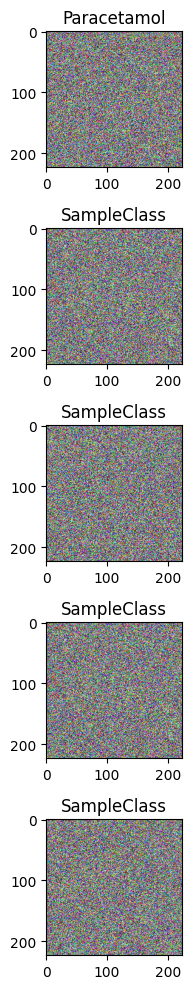

In [2]:
# %% load dataset and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator #data augmentation
from tensorflow.keras.layers import Resizing, Rescaling, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

#load data
dataset = "Drug Vision/Data Combined" #verinin oldugu dosya yolu
image_dir = Path(dataset)

filepaths = list(image_dir.glob("**/*.jpg")) + list(image_dir.glob("**/*.jpeg"))

if len(filepaths) == 0:
    raise FileNotFoundError("Belirtilen klasörde .jpg veya .jpeg uzantılı görsel bulunamadı!")

labels = [path.parent.name for path in filepaths]
filepaths = pd.Series(filepaths, name="filepath").astype(str)
labels = pd.Series(labels, name="label")
image_df = pd.concat([filepaths, labels], axis=1)

# veri gorsellestirme
random_index = np.random.randint(0, len(image_df), 25)
fig, axes = plt.subplots(nrows = 5, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.label[random_index[i]])
plt.tight_layout()

# preprocessing
# train test split
train_df, test_df = train_test_split(image_df, test_size=0.01, random_state=42, shuffle=True)

# data augmentation: veri arttirimi
train_generator = ImageDataGenerator(
                        preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                        validation_split = 0.2)

test_generator = ImageDataGenerator(
                        preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# egitim, test ve val verilerini akisa alalim
train_images = train_generator.flow_from_dataframe(
                dataframe = train_df,                # düzeltildi: image_df -> train_df
                x_col = "filepath", # goruntu yolu
                y_col = "label",  
                target_size = (224,224), #goruntulerin hedef boyutu
                color_mode = "rgb", # renkli goruntu
                class_mode = "categorical",
                batch_size = 64,
                shuffle = True,
                seed = 42,
                subset = "training" #egitim seti
            )

val_images = train_generator.flow_from_dataframe(
                dataframe = train_df,
                x_col = "filepath", # goruntu yolu
                y_col = "label",
                target_size = (224,224), # goruntulerin hedef boyutu
                color_mode = "rgb", # renkli goruntu
                class_mode = "categorical",
                batch_size = 64,
                shuffle = True,
                seed = 42,
                subset = "validation" # validation seti
            )

test_images = test_generator.flow_from_dataframe(
                dataframe = test_df,
                x_col = "filepath", # goruntu yolu
                y_col = "label",
                target_size = (224,224), # goruntulerin hedef boyutu
                color_mode = "rgb", # renkli goruntu
                class_mode = "categorical",
                batch_size = 64,
            )

resize_and_rescale = tf.keras.Sequential([
        Resizing(224,224), # goruntuleri 224x224 yenden boyutlandir
        Rescaling(1.0/255) # normalization
])

In [4]:
# %% transfer learning modelimiz: vgg16 and training

# vgg16 onceden egitilen model
pretrained_model = VGG16(
                        input_shape = (224,224,3), # goruntunun boyutu
                        include_top = False, # siniflandirma katmanini dahil etme
                        weights = "imagenet", # hangi veri seti ile egitildigini
                        pooling = "avg"
                        )

pretrained_model.trainable = False

#callback
checkpoint_path = "pharmaceutical_drugs_and_vitamins_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(filepath = checkpoint_path,
                                     save_weights_only = True, #modelin sadcee agitliklarini kaydet
                                     monitor = "val_accuracy",
                                     save_best_only = True, # sadece en iyi modeli kaydet
                                     )

# 3 epoch kadar val_accuracy degerinde bir iyilesme olmazsa egitimi durur
early_stopping = EarlyStopping(monitor = "val_accuracy",
                              patience = 3, # 3 epoch kadar val_accuracy degerini izle
                              restore_best_weights = True
                              )

# vgg16 kullanarak build model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation = "relu")(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation = "softmax")(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

# compile
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# training
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=2,
    callbacks=[early_stopping, checkpoint_callback]
)

# https://keras.io/api/applications/

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,912,322 (56.89 MB)

 Trainable params: 197,634 (772.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8750 - loss: 0.2420 - val_accuracy: 0.5000 - val_loss: 2.0958
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0587 - val_accuracy: 0.5000 - val_loss: 2.4065


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 3.5550
Loss: 3.55, Accuracy: 0.0


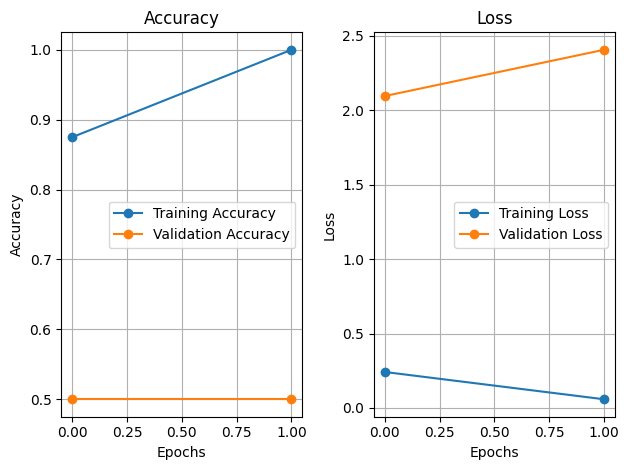

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


In [5]:
# %% test
loss, accuracy = model.evaluate(test_images, verbose = 1)
print(f"Loss: {loss:.3}, Accuracy: {accuracy:.3}")

plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], marker = "o", label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], marker = "o", label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], marker = "o", label = "Training Loss")
plt.plot(history.history["val_loss"], marker = "o", label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1)

labels = (train_images.class_indices)
labels = (dict(v,k) for k,v in labels.items())